In [1]:
import os
os.environ['DJANGO_SETTINGS_MODULE'] = 'ClusterCast.settings'
import test_utils
import django
django.setup()
import sys
sys.path.append("/home/ajp031/StockDeepLearning/ClusterCast/ClusterCast")
from asgiref.sync import sync_to_async
from importlib import reload
import ClusterPipeline.models.ClusterProcessing as cp
from copy import deepcopy
import numpy as np
import tfts
from tfts import AutoModel, KerasTrainer
import tensorflow as tf
from tensorflow.keras.backend import clear_session

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fcf6b753760>
Traceback (most recent call last):
  File "/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
2024-03-25 21:12:40.595788: I tensorflow/core/pl

In [2]:
reload(test_utils)

<module 'test_utils' from '/home/ajp031/ClusterCastProd/test_utils.py'>

In [3]:
group_ids = [6]
groups = await test_utils.extract_cluster_groups(group_ids)

Creating and Processing Dataset
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Empty DataFrame
Columns: []
Index: [2007-01-03 00:00:00]
Momentum Features Created
Scaling Standard
Scaling Quant Min Max Features
Quant Min Max Features Scaled
RandomForest Compete
Dataset Preprocessing Complete
Creating Sequences
Scaling Sequences
Scaling Sequences Complete
Sequence Preprocessing Complete
Loading Saved Clusters
Finished Loading Saved Clusters


In [4]:
clusters = await test_utils.get_all_clusters(groups)

In [5]:
cluster_of_interest_id = 40
cluster_of_interest = [cluster for cluster in clusters if cluster.id == cluster_of_interest_id][0]

In [6]:
features = groups[0].group_params.training_features

features

['pctChgopen',
 'pctChghigh',
 'pctChglow',
 'pctChgclose',
 'pctChgvolume',
 'pctChgVix',
 'pctDiff+sma5_close',
 'pctDiff+sma5_sma10',
 'pctDiff+sma5_sma20',
 'pctDiff+sma5_sma30',
 'pctDiff+sma5_sma50',
 'pctDiff+sma5_sma100',
 'pctDiff+sma5_sma200',
 'pctDiff+sma10_sma20',
 'pctDiff+sma10_sma30',
 'pctDiff+sma10_sma50',
 'pctDiff+sma10_sma100',
 'pctDiff+sma10_sma200',
 'pctDiff+sma20_sma30',
 'pctDiff+sma20_sma50',
 'pctDiff+sma20_sma100',
 'pctDiff+sma20_sma200',
 'pctDiff+sma30_sma50',
 'pctDiff+sma30_sma100',
 'pctDiff+sma30_sma200',
 'pctDiff+sma50_sma100',
 'pctDiff+sma50_sma200',
 'pctDiff+sma100_sma200',
 'pctDiff+sma10_close',
 'pctDiff+sma20_close',
 'pctDiff+sma30_close',
 'pctDiff+sma50_close',
 'pctDiff+sma100_close',
 'pctDiff+sma200_close',
 'pctDiff+ema5_close',
 'pctDiff+ema10_close',
 'pctDiff+ema20_close',
 'pctDiff+ema30_close',
 'pctDiff+ema50_close',
 'pctDiff+ema100_close',
 'pctDiff+ema200_close',
 'pctDiff+ema5_ema10',
 'pctDiff+ema5_ema20',
 'pctDiff+ema5_

In [7]:
cur_group = groups[0]

In [8]:
# cur_group = await test_utils.recreate_group(cur_group)

In [9]:

X_train, y_train, X_test, y_test = cur_group.get_3d_array() 
X_train = X_train.copy()[::-1]
y_train = y_train.copy()[::-1]
X_test = X_test.copy()[::-1]
y_test = y_test.copy()[::-1]
cluster_features = cur_group.group_params.cluster_features
X_feature_dict = cur_group.group_params.X_feature_dict
y_feature_dict = cur_group.group_params.y_feature_dict
training_dict = {}
training_dict['0'] = (0,(X_train, y_train, X_test, y_test))
print(training_dict['0'][1][0].shape)
print(training_dict['0'][1][1].shape)
print(training_dict['0'][1][2].shape)
print(training_dict['0'][1][3].shape)

(3390, 75, 517)
(3390, 55)
(783, 75, 517)
(783, 55)


In [10]:
print(len(X_feature_dict))
print(len(cur_group.group_params.X_cols))

517
517


In [11]:
print(X_feature_dict)

{'Vix': 0, 'bb_high10': 1, 'bb_high20': 2, 'bb_high40': 3, 'bb_high60': 4, 'bb_indicator10': 5, 'bb_indicator10-3': 6, 'bb_indicator10-6': 7, 'bb_indicator20': 8, 'bb_indicator20-3': 9, 'bb_indicator20-6': 10, 'bb_indicator40': 11, 'bb_indicator40-3': 12, 'bb_indicator40-6': 13, 'bb_indicator60': 14, 'bb_indicator60-3': 15, 'bb_indicator60-6': 16, 'bb_low10': 17, 'bb_low20': 18, 'bb_low40': 19, 'bb_low60': 20, 'close': 21, 'deriv+ema10': 22, 'deriv+ema10-3': 23, 'deriv+ema10-6': 24, 'deriv+ema100': 25, 'deriv+ema100-3': 26, 'deriv+ema100-6': 27, 'deriv+ema20': 28, 'deriv+ema20-3': 29, 'deriv+ema20-6': 30, 'deriv+ema200': 31, 'deriv+ema200-3': 32, 'deriv+ema200-6': 33, 'deriv+ema30': 34, 'deriv+ema30-3': 35, 'deriv+ema30-6': 36, 'deriv+ema5': 37, 'deriv+ema5-3': 38, 'deriv+ema5-6': 39, 'deriv+ema50': 40, 'deriv+ema50-3': 41, 'deriv+ema50-6': 42, 'deriv+sma10': 43, 'deriv+sma10-3': 44, 'deriv+sma10-6': 45, 'deriv+sma100': 46, 'deriv+sma100-3': 47, 'deriv+sma100-6': 48, 'deriv+sma20': 49,

In [12]:
next_clusters = test_utils.cluster_a_group(cur_group,training_dict['0'][1],4)
next_label = 2
training_dict['1'] = next_clusters[next_label]

(75, 2)


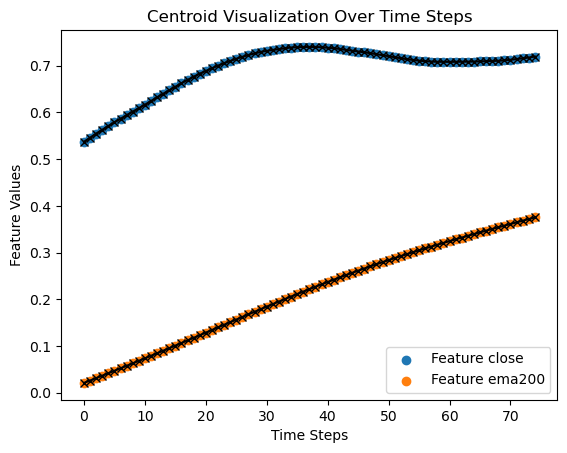

(75, 2)


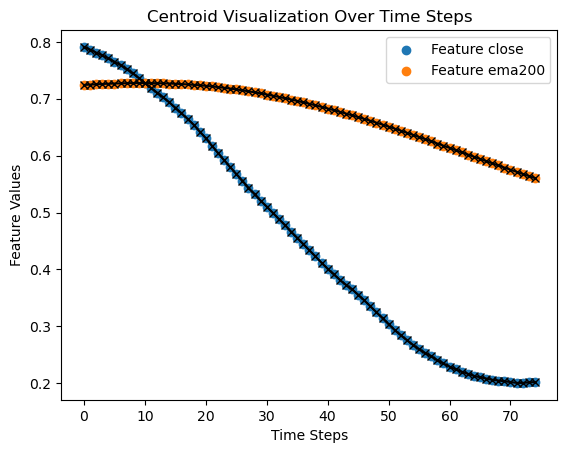

(75, 2)


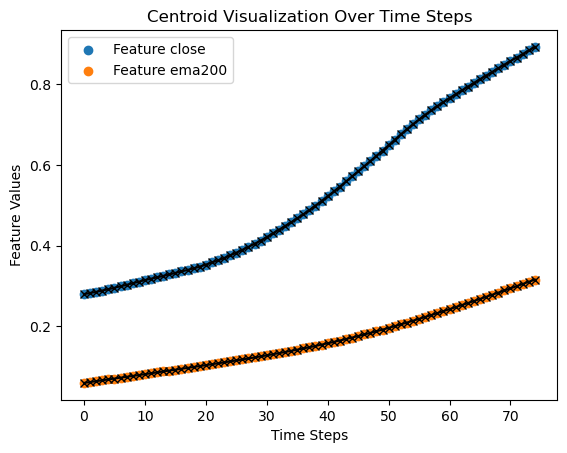

(75, 2)


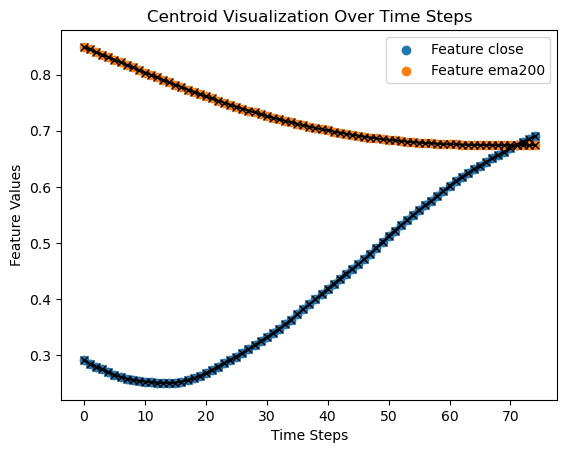

In [13]:
for i in range(len(next_clusters)): 
    print(next_clusters[i][0].shape)
    plot = test_utils.visualize_cluster_centroid(next_clusters[i][0],cluster_features)
    plot.show()

(75, 2)


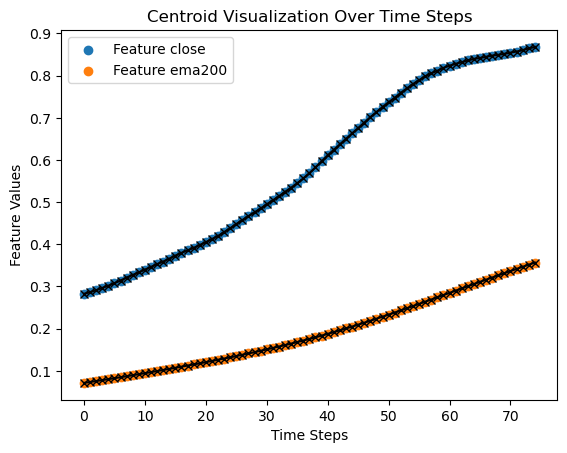

(75, 2)


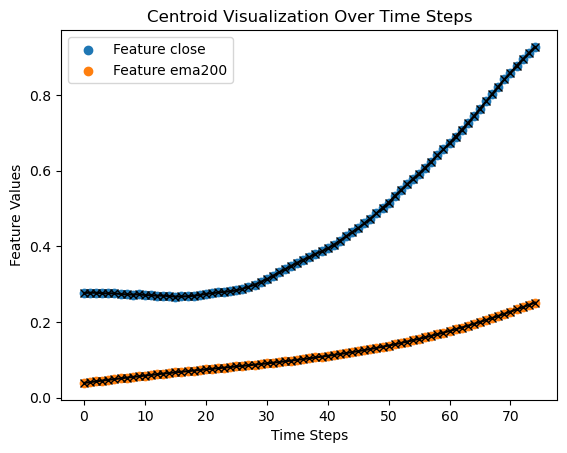

In [14]:
next_clusters = test_utils.cluster_a_group(cur_group,training_dict['1'][1],2)
for i in range(len(next_clusters)): 
    print(next_clusters[i][0].shape)
    plot = test_utils.visualize_cluster_centroid(next_clusters[i][0],cluster_features)
    plot.show()
next_label = 0
training_dict['2'] = next_clusters[next_label]

(75, 2)


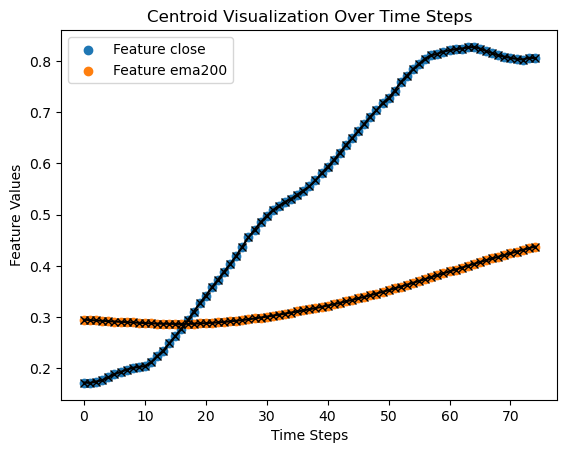

(75, 2)


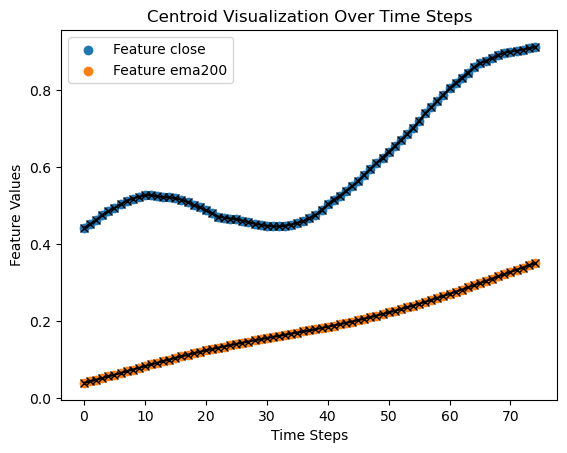

(75, 2)


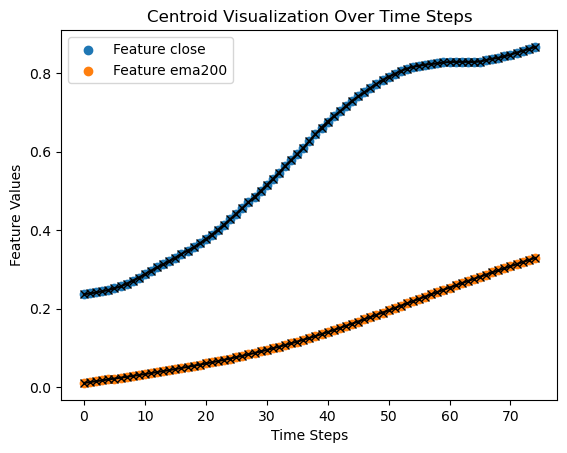

In [15]:
next_clusters = test_utils.cluster_a_group(cur_group,training_dict['2'][1],3)
for i in range(len(next_clusters)): 
    print(next_clusters[i][0].shape)
    plot = test_utils.visualize_cluster_centroid(next_clusters[i][0],cluster_features)
    plot.show()
next_label = 1
training_dict['3'] = (next_clusters[next_label])

In [18]:
import random
target_features = [] 
# target_features += ['pctChgclose{}_target'.format(i) for i in range(-14, 0) ]
# target_features += ['pctChgclose-0_target']
target_features += ['pctChgclose+{}_target'.format(i) for i in range(1, 16) ]
training_features = random.sample(features, 20)
training_features += ['pctChgclose']


In [19]:
print(training_features)

['pctDiff+sma20_sma30', 'deriv+smaVol50', 'deriv+smaVol5', 'pctDiff+smaVol50_volume', 'opLo', 'deriv+ema30', 'pctDiff+ema5_ema100', 'pctDiff+ema100_ema200', 'deriv+ema50', 'pctDiff+bb_high_low10', 'pctDiff+sma20_close', 'pctDiff+ema20_close', 'pctDiff+sma30_sma200', 'pctDiff+sma10_close', 'deriv+sma10', 'pctDiff+ema20_ema200', 'bb_indicator60', 'pctDiff+sma10_sma20', 'pctDiff+smaVol5_smaVol20', 'pctDiff+ema5_ema20', 'pctChgclose']


In [20]:
reload(test_utils)

<module 'test_utils' from '/home/ajp031/ClusterCastProd/test_utils.py'>

In [21]:
print(target_features)
print(len(target_features))

['pctChgclose+1_target', 'pctChgclose+2_target', 'pctChgclose+3_target', 'pctChgclose+4_target', 'pctChgclose+5_target', 'pctChgclose+6_target', 'pctChgclose+7_target', 'pctChgclose+8_target', 'pctChgclose+9_target', 'pctChgclose+10_target', 'pctChgclose+11_target', 'pctChgclose+12_target', 'pctChgclose+13_target', 'pctChgclose+14_target', 'pctChgclose+15_target']
15


In [22]:
centroid =  training_dict['0'][0]
X_train, y_train, X_test, y_test = training_dict['0'][1]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(y_feature_dict)

(3390, 75, 517)
(3390, 55)
(783, 75, 517)
(783, 55)
{'pctChgclose+10_target': 0, 'pctChgclose+11_target': 1, 'pctChgclose+12_target': 2, 'pctChgclose+13_target': 3, 'pctChgclose+14_target': 4, 'pctChgclose+15_target': 5, 'pctChgclose+16_target': 6, 'pctChgclose+17_target': 7, 'pctChgclose+18_target': 8, 'pctChgclose+19_target': 9, 'pctChgclose+1_target': 10, 'pctChgclose+20_target': 11, 'pctChgclose+21_target': 12, 'pctChgclose+22_target': 13, 'pctChgclose+23_target': 14, 'pctChgclose+24_target': 15, 'pctChgclose+25_target': 16, 'pctChgclose+2_target': 17, 'pctChgclose+3_target': 18, 'pctChgclose+4_target': 19, 'pctChgclose+5_target': 20, 'pctChgclose+6_target': 21, 'pctChgclose+7_target': 22, 'pctChgclose+8_target': 23, 'pctChgclose+9_target': 24, 'pctChgclose-0_target': 25, 'pctChgclose-10_target': 26, 'pctChgclose-11_target': 27, 'pctChgclose-12_target': 28, 'pctChgclose-13_target': 29, 'pctChgclose-14_target': 30, 'pctChgclose-1_target': 31, 'pctChgclose-2_target': 32, 'pctChgclose

In [23]:
bb_index = X_feature_dict['pctChgclose']
X_train[:,:,bb_index]

array([[-0.34100944,  1.2143513 ,  0.9792311 , ...,  0.35068268,
        -1.6371541 ,  1.4401177 ],
       [-0.04275994, -0.34100944,  1.2143513 , ...,  0.673366  ,
         0.35068268, -1.6371541 ],
       [-0.13009156, -0.04275994, -0.34100944, ..., -0.43142956,
         0.673366  ,  0.35068268],
       ...,
       [-0.40964293,  0.17875212,  3.9908276 , ...,  0.3161575 ,
         1.3000968 , -0.20307013],
       [ 1.020757  , -0.40964293,  0.17875212, ..., -0.13234028,
         0.3161575 ,  1.3000968 ],
       [ 1.020757  ,  1.020757  , -0.40964293, ..., -0.03519929,
        -0.13234028,  0.3161575 ]], dtype=float32)

In [24]:
# cur_group.run_clustering()
# all_centroids = cur_group.cluster_centers

# closted_centroid_label = test_utils.find_closest_centroid(centroid,all_centroids)
# print(closted_centroid_label)



In [25]:
# print(cur_group.cluster_centers.shape)   


In [26]:
# print(closted_centroid_label)
# test_utils.visualize_cluster_centroid(centroid,cluster_features).show()
# test_utils.visualize_cluster_centroid(all_centroids[closted_centroid_label],cluster_features).show()


In [27]:
print(len(cur_group.clusters))

10


In [28]:

X_train_filtered = test_utils.filter_by_features(X_train, training_features, X_feature_dict)
X_test_filtered = test_utils.filter_by_features(X_test, training_features, X_feature_dict)
y_train_filtered = test_utils.filter_y_by_features(y_train, target_features, y_feature_dict)
y_test_filtered = test_utils.filter_y_by_features(y_test, target_features, y_feature_dict)
print(X_train_filtered.shape)
print(y_train_filtered.shape)
print(X_test_filtered.shape)
print(y_test_filtered.shape)

[10, 17, 18, 19, 20, 21, 22, 23, 24, 0, 1, 2, 3, 4, 5]
[10, 17, 18, 19, 20, 21, 22, 23, 24, 0, 1, 2, 3, 4, 5]
(3390, 75, 21)
(3390, 15)
(783, 75, 21)
(783, 15)


In [29]:
print(X_train_filtered[0,0,:])

[ 0.72712684 -0.41916203 -0.03135502  2.0468354  -1.141777    3.1963477
  1.1346328   0.6053074   2.3381288  -0.16680254  0.7683313   0.7783088
  0.6070343   0.23638432  3.04005     0.9299601   0.75702155  1.1646591
  0.71769863  1.0623869  -0.34100944]


In [49]:
custom_model_params = {"rnn_type": "gru",
    "bi_direction": False,
    "rnn_size": 64,
    "dense_size": 64,
    "num_stacked_layers": 1,
    "scheduler_sampling": 0,  # teacher forcing
    "use_attention": True,
    "attention_sizes": 64,
    "attention_heads": 2,
    "attention_dropout": 0,
    "skip_connect_circle": False,
    "skip_connect_mean": False,
}
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(0.001)
lr_scheduler=None
model = AutoModel('transformer',predict_length = 15, custom_model_params = custom_model_params )

In [50]:
train = [X_train_filtered, y_train_filtered]
valid = [X_test_filtered, y_test_filtered]

In [51]:

opt = tf.keras.optimizers.Adam(0.001)
loss_fn = tf.keras.losses.MeanSquaredError()
trainer = KerasTrainer(model, loss_fn=loss_fn, optimizer=opt)
trainer.train(train, valid, n_epochs=12, batch_size=32)

Epoch 1/12
106/106 - 354s - loss: 0.7599 - val_loss: 0.2387 - 354s/epoch - 3s/step
Epoch 2/12
106/106 - 345s - loss: 0.3145 - val_loss: 0.2326 - 345s/epoch - 3s/step
Epoch 3/12
106/106 - 349s - loss: 0.2863 - val_loss: 0.2328 - 349s/epoch - 3s/step
Epoch 4/12
106/106 - 350s - loss: 0.2782 - val_loss: 0.2314 - 350s/epoch - 3s/step
Epoch 5/12
106/106 - 347s - loss: 0.2732 - val_loss: 0.2321 - 347s/epoch - 3s/step
Epoch 6/12
106/106 - 347s - loss: 0.2693 - val_loss: 0.2326 - 347s/epoch - 3s/step
Epoch 7/12
106/106 - 349s - loss: 0.2631 - val_loss: 0.2379 - 349s/epoch - 3s/step
Epoch 8/12
106/106 - 349s - loss: 0.2575 - val_loss: 0.2382 - 349s/epoch - 3s/step
Epoch 9/12
106/106 - 347s - loss: 0.2557 - val_loss: 0.2353 - 347s/epoch - 3s/step
Epoch 10/12
106/106 - 346s - loss: 0.2518 - val_loss: 0.2409 - 346s/epoch - 3s/step
Epoch 11/12
106/106 - 346s - loss: 0.2488 - val_loss: 0.2494 - 346s/epoch - 3s/step
Epoch 12/12
106/106 - 345s - loss: 0.2464 - val_loss: 0.2457 - 345s/epoch - 3s/step


In [52]:
num_days = 15
y_pred = trainer.predict(valid[0])
attention_model_accuracy, attention_results = test_utils.eval_pred(y_test_filtered, y_pred, num_days)

15


In [ ]:
# for layer in trainined_attention_model.layers:
#     if 'freeze' in layer.name:
#         layer.trainable = False
#         continue
#     if 'input' in layer.name:
#         continue
#     layer.set_weights(decoder_weights[layer.name])

In [53]:
reload(test_utils)

<module 'test_utils' from '/home/ajp031/ClusterCastProd/test_utils.py'>

In [54]:
print(attention_model_accuracy)
test_utils.visualize_future_distribution(attention_results)

Cluster Number:
Accuracy1D 49.17% PredictedRet: 0.08972525596618652 ActRet: 0.011991628828383553
Accuracy2D 47.64% PredictedRet: 0.1773451268672943 ActRet: 0.022636181076020383
Accuracy3D 50.57% PredictedRet: 0.2726341485977173 ActRet: 0.033184853219754264
Accuracy4D 48.91% PredictedRet: 0.36677902936935425 ActRet: 0.044452795488843136
Accuracy5D 50.83% PredictedRet: 0.4596608281135559 ActRet: 0.05747275976945871
Accuracy6D 50.83% PredictedRet: 0.553550124168396 ActRet: 0.0719027714983716
Accuracy7D 51.47% PredictedRet: 0.6507785320281982 ActRet: 0.08518197290458994
Accuracy8D 50.45% PredictedRet: 0.750873327255249 ActRet: 0.09864561742044971
Accuracy9D 49.94% PredictedRet: 0.8520467281341553 ActRet: 0.11233352922708377
Accuracy10D 50.32% PredictedRet: 0.9532751441001892 ActRet: 0.12503108260382947
Accuracy11D 49.81% PredictedRet: 1.0539671182632446 ActRet: 0.13795858933465463
Accuracy12D 51.6% PredictedRet: 1.1549276113510132 ActRet: 0.15088736439598927
Accuracy13D 51.34% PredictedRet

In [55]:
centroid =  training_dict['2'][0]
X_train_smaller, y_train_smaller, X_test_smaller, y_test_smaller= training_dict['2'][1]
# X_train_larger = np.concatenate((X_train, X_train_larger), axis=0)
# y_train_larger = np.concatenate((y_train, y_train_larger), axis=0)
# X_test_larger = np.concatenate((X_test, X_test_larger), axis=0)
# y_test_larger = np.concatenate((y_test, y_test_larger), axis=0)

# X_train_larger = np.concatenate((X_train, X_train_larger), axis=0)
# y_train_larger = np.concatenate((y_train, y_train_larger), axis=0)
# X_test_larger = np.concatenate((X_test, X_test_larger), axis=0)
# y_test_larger = np.concatenate((y_test, y_test_larger), axis=0)

X_train_smaller_filtered = test_utils.filter_by_features(X_train_smaller, training_features, X_feature_dict)
X_test_smaller_filtered = test_utils.filter_by_features(X_test_smaller, training_features, X_feature_dict)
y_train_smaller_filtered = test_utils.filter_y_by_features(y_train_smaller, target_features, y_feature_dict)
y_test_smaller_filtered = test_utils.filter_y_by_features(y_test_smaller, target_features, y_feature_dict)



print(X_train_smaller_filtered.shape)
print(y_train_smaller_filtered.shape)
print(X_test_smaller_filtered.shape)
print(y_test_smaller_filtered.shape)

[10, 17, 18, 19, 20, 21, 22, 23, 24, 0, 1, 2, 3, 4, 5]
[10, 17, 18, 19, 20, 21, 22, 23, 24, 0, 1, 2, 3, 4, 5]
(763, 75, 21)
(763, 15)
(144, 75, 21)
(144, 15)


In [56]:
train = [X_train_smaller_filtered, y_train_smaller_filtered]
valid = [X_test_smaller_filtered, y_test_smaller_filtered]

In [57]:
opt = tf.keras.optimizers.Adam(0.0001)
loss_fn = tf.keras.losses.MeanSquaredError()
trainer = KerasTrainer(model, loss_fn=loss_fn, optimizer=opt)
trainer.train(train, valid, n_epochs=2, batch_size=16)

Epoch 1/2
48/48 - 156s - loss: 0.2345 - val_loss: 0.1694 - 156s/epoch - 3s/step
Epoch 2/2
48/48 - 149s - loss: 0.2320 - val_loss: 0.1773 - 149s/epoch - 3s/step


In [58]:
y_pred = trainer.predict(valid[0])
attention_model_accuracy, attention_results = test_utils.eval_pred(y_test_smaller_filtered, y_pred, num_days)

15


In [ ]:
benchmark_model = test_utils.create_attention_model(input_steps=X_train.shape[1],output_steps=len(target_features),features=len(training_features))
benchark_model = test_utils.train_model(benchmark_model, (X_train_smaller, y_train_smaller, X_test_smaller, y_test_smaller), training_features,
                                        target_features, X_feature_dict, y_feature_dict,
                                        epochs = 250, batch_size = 32, lr = 0.001, early_stopping_patience = 30,
                                        loss = 'mse')

In [ ]:
# benchark_model = test_utils.train_model(benchmark_model, (X_train_smaller, y_train_smaller, X_test_smaller, y_test_smaller), training_features,
#                                         target_features, X_feature_dict, y_feature_dict,
#                                         epochs = 250, batch_size = 16, lr = 0.0001, early_stopping_patience = 30,
#                                         loss = test_utils.custom_profit_loss_percent_change)

In [ ]:
bench_model_accuracy, bench_results = test_utils.eval_model(X_test_smaller_filtered, y_test_smaller_filtered, benchmark_model)

In [59]:
print("FINE TUNED MODEL")
print(attention_model_accuracy)
test_utils.visualize_future_distribution(attention_results)

FINE TUNED MODEL
Cluster Number:
Accuracy1D 48.61% PredictedRet: 0.10211601853370667 ActRet: 0.016438298270158056
Accuracy2D 53.47% PredictedRet: 0.21472668647766113 ActRet: 0.027607623319555488
Accuracy3D 58.33% PredictedRet: 0.3342795968055725 ActRet: 0.028509384001760434
Accuracy4D 56.94% PredictedRet: 0.45179155468940735 ActRet: 0.026885495404712856
Accuracy5D 59.03% PredictedRet: 0.5677011013031006 ActRet: 0.011235061347381108
Accuracy6D 56.94% PredictedRet: 0.6843534111976624 ActRet: -0.01589727364221795
Accuracy7D 59.03% PredictedRet: 0.8046238422393799 ActRet: -0.020011967785346012
Accuracy8D 59.72% PredictedRet: 0.927882194519043 ActRet: -0.042832162295882076
Accuracy9D 56.94% PredictedRet: 1.0526819229125977 ActRet: -0.08744996598559535
Accuracy10D 55.56% PredictedRet: 1.177053451538086 ActRet: -0.1217085953685455
Accuracy11D 56.94% PredictedRet: 1.298876404762268 ActRet: -0.14091537973015672
Accuracy12D 56.94% PredictedRet: 1.4179930686950684 ActRet: -0.1547969973180443
Accu

In [48]:
print("BENCHMARK MODEL")
print(bench_model_accuracy)
test_utils.visualize_future_distribution(bench_results)

BENCHMARK MODEL


NameError: name 'bench_model_accuracy' is not defined

In [ ]:
clear_session()